# Globular Cluster Spectroscopy and Photometry Demo
This is a version of the demo that is intended to show the some of the ingredients of and how to use *prospector* for fitting photometry and uncalibrated spectra of potential globular clusters in nearby galaxies.  So, the stellar population parameters are very simple.

# Installation

I highly recommend installing Python using Astroconda/Miniconda and then installing *prospector* and its dependencies in a "conda" environment.  You should have received with this notebook a few files (`install.sh`, `pro.yml`, and `fsps.Makefile`) that will help you do this.  The `install.sh` file can be followed step-by-step to both install Miniconda and *FSPS* and set up an enviroment with all the required dependencies.  You should edit this file for your preferred local filesystem locations, and add the noted enviornment variables in your `.bashrc` file. After this procedure, as long as you activate the environment first `conda activate pro` you should be able to run prospector.

Assuming you've installed everything and started up this notebook, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *

VERS = sys.version_info[0]

%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now, and just look at the versions so you know what's working for me:

In [2]:
import fsps
import sedpy
import prospect

vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

numpy: 1.17.2
scipy: 1.3.1
h5py: 2.10.0
fsps: 0.3.0
prospect: 0.4.0


We'll also use external packages for sampling the posterior.  Let's make sure we have those now.

In [3]:
import dynesty
print(dynesty.__version__)

1.0.0


# Setup

*Prospector* requires several major ingredients to conduct a fit.  These are:
  1. The data we intend to fit as a dictionary called `obs`
  3. A stellar population synthesis object (a *source*) to predict basic spectra from parameters.  We will usually call this `sps`
  2. The model, consisting of a set of parameters and their prior distributions. For this we will use a special object that we'll call `model` which describes, stores, translates, and contains prior information about the parameters.
  4. A likelihood or posterior probability function
  
It can also useful to collect the meta-parameters controlling how these ingredients are created and how the fit is conducted in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `build_x()` functions.

## The data to be fit: `build_obs()`

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed to the model object to specify which data to predict.  It is also passed to the likelihood functions for calculating the likelihood of the data for a given model.

**Units:** The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.  Also note that mask values should be `True` for data that you want to fit, and `False` for data that is to be ignored in the likelihood calculation.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
We will do this through a `build_obs` method, that takes some meta-parameters.  In this example we will assume the file is stored in simple ascii tables, two for each object.  One of them holds the photometric data (`<object_name>.phot.dat`) and one the spectroscopic data (`<object_name>.spec.dat`).  The format of these files can be seen in the `gc1.*.dat` files distributed with this notebook (the number of spaces between columns does not matter)

Photometric file:
```
filtername  flux(mJy) unc(mJy)
galex_NUV        0.5    0.03
sdss_r0          1.0     0.05
twomass_Ks       2.0     0.10
...
```
Here the filternames should be one of the filters available in *sedpy*, see https://github.com/bd-j/sedpy/tree/master/sedpy/data/filters

Spectroscopic file:
```
wavelength(AA)  flux(mJy)  unc(mJy) resolution(km/s)
5000.0               0.7      0.1   300.0
5100.0               0.71    0.08   299.9
...
```

In [4]:
def build_obs(object_name="gc1", **extras):
    """Build a dictionary of observational data.  In this example 
    we will read from text files named <object_name>.spec.dat and <object_name>.phot.dat
    
    Parameters
    ----------
    object_name : string
        The name of the object, used to find data files
    
    Returns
    -------
    obs : dictionary
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    from sedpy.observate import load_filters

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    phot_file = "{}.phot.dat".format(object_name)
    spec_file = "{}.spec.dat".format(object_name)
    
    # --- Photometric Data ---
    
    # this is the description of the column formats
    if VERS == 2:
        stype = "S20"
    elif VERS == 3:
        stype = "U20"
    cols = [("filtername", stype), ("flux", np.float), ("unc", np.float)]
    # read the file
    phot = np.genfromtxt(phot_file, dtype=np.dtype(cols), skip_header=1)

    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resulting list of Filter objects in the "filters" key of the `obs` dictionary
    # These Filter objects will perform projections of the model SED onto the filters.
    obs["filters"] = load_filters(phot["filtername"])

    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    obs["maggies"] = phot["flux"] * 1e-3 / 3631

    # And now we store the uncertainties (again in units of maggies)
    obs["maggies_unc"] = phot["unc"] * 1e-3 / 3631

    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    obs["phot_mask"] = np.array(['spitzer' not in f.name for f in obs["filters"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])

    
    # --- Spectroscopic Data ---

    # this is the description of the column formats
    cols = [("wavelength", np.float), ("flux", np.float),
            ("unc", np.float), ("resolution", np.float)]
    # read the file
    spec = np.genfromtxt(spec_file, dtype=np.dtype(cols), skip_header=1)

    # The wavelengths in vacuum angstroms
    obs["wavelength"] = spec["wavelength"]
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = spec["flux"] * 1e-3 / 3631
    # (spectral uncertainties are given here)
    obs['unc'] = spec["unc"] * 1e-3 / 3631
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = spec["unc"] > 0
    # add this key (the instrumental resolution in km/s) so we can pass it to build_sps later
    obs["resolution"] = spec["resolution"]

    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    # That's it!
    return obs

And we will store some meta-parameters that control the input arguments to this method:

In [5]:
run_params = {}
run_params["object_name"] = "gc1"

Let's take a look at the final `obs` disctionary and also plot up our data.

Obs Dictionary Keys:

dict_keys(['filters', 'maggies', 'maggies_unc', 'phot_mask', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'mask', 'resolution', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(twomass_Ks)]


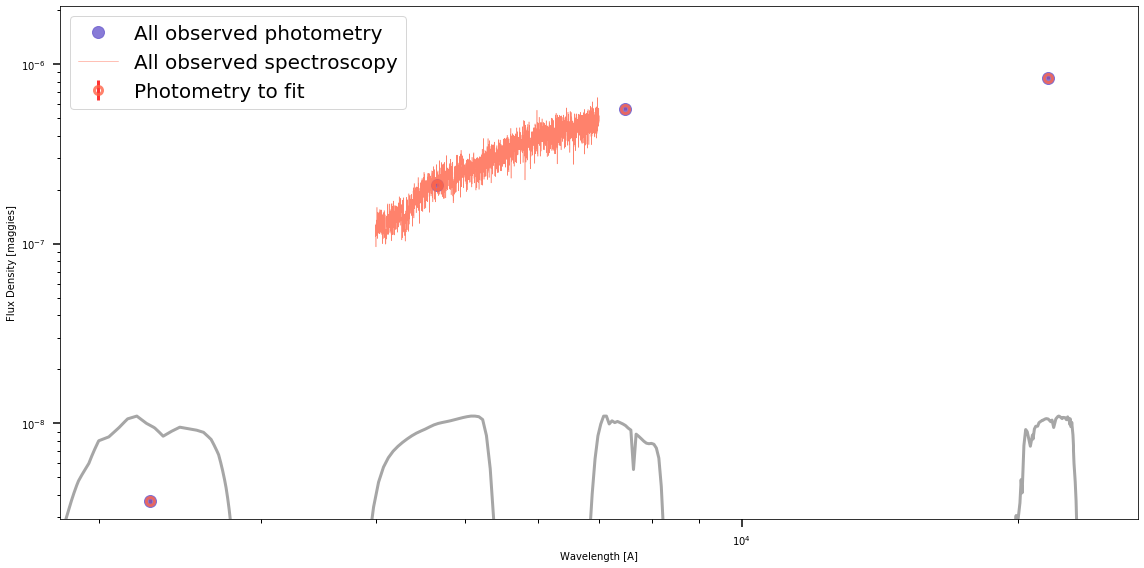

In [6]:
# Build the obs dictionary using the meta-parameters
obs = build_obs(**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
figure(figsize=(16,8))

# plot all the photometry
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the bands we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

#plot the spectrum
plot(obs["wavelength"], obs['spectrum'],
     label='All observed spectroscopy',
     alpha=0.8, ls='-', lw=0.5,
     color='tomato')

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

## The source object: `build_sps()`

We need an object that will build SEDs for a given set of parameters.  In *prospector* we call these *sps* objects.  Given a dictionary of parameters (provided by the model object below), they must be able to return a spectrum and photometry -- corresponding to the data in the `obs` dictionary -- and maybe some ancillary information.  The generation of spectra and photometry is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in *prospector* we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations:

 * `prospect.sources.CSPSpecBasis` works with (linear combinations of) composite stellar populations,  as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  
 * `prospect.sources.FastStepBasis` for non-parametric SFH, specifically step function SFHs.
 * `prospect.sources.FastSSPBasis` for single-age, single metallicity populations (FSPS `sfh_type=0`)

Again, it can be helpful to encapsulate the loading of the sps object in a `build_sps` method, with meta-parameters controlling the how the object is instantiated.

In this example, we are going to pass the `obs` dictionary created above because it has information about the instrumental resolution that we will use to pre-smooth the SSPs before fitting.  But first we need a little function that will do this smoothing.  In the next cell we write a function that takes a pair of wavelength, resolution arrays and tells FSPS to smooth the SSPs to this resolution, accounting for the resolution of the FSPS spectral library .

In [7]:
def set_instrumental_lsf(ssp, wave_obs, sigma_v, zred=0.0, miles_fwhm_aa=2.54):
    """This tells FSPS to smooth the SSPs by the given instrumental velocity
    dispersion, accounting for the library resolution.

    Parameters
    ----------
    ssp: fsps.StellarPopulation() instance

    wave_obs: ndarray of shape (n_wave,)
        The observed frame wavelengths of the data, in Angstroms

    sigma_v: ndarray of shape (n_wave,)
        The instrumental resolution at each wavelength, expressed as a velocity
        dispersion in km/s
    """
    ssp.libraries[1].decode("utf-8") == "miles", "Please change FSPS to the MILES libraries."
    ssp.params['smooth_lsf'] = True

    # Convert restframe library resolution to observed frame velocity dispersion
    lightspeed = 2.998e5  # km/s
    wave_rest = wave_obs / (1 + zred)
    sigma_v_miles = lightspeed * miles_fwhm_aa / 2.355 / wave_rest

    # Get the duadrature difference between the the instrumental resolution and
    # the observed frame library resolution
    # (Zero and negative values are skipped by FSPS)
    dsv = np.sqrt(np.clip(sigma_v**2 - sigma_v_miles**2, 0, np.inf))

    # Restrict to regions where MILES is used
    good = (wave_rest > 3525.0) & (wave_rest < 7500) & np.isfinite(dsv)

    # Tell FSPS about it
    ssp.set_lsf(wave_rest[good], dsv[good])

Ok, now we can use this function in our `build_sps` method to optionally smooth the SSPs by the instrumental resolution listed in the `gc1.spec.dat` file, as long as we pass it a dictionary with the resolution information

In [8]:
def build_sps(zcontinuous=1, set_lsf=True, object_redshift=0.0, obs=None, **extras):
    """
    Parameters
    ----------
    zcontinuous : int or bool
        A value of 1 insures that we use interpolation between SSPs to
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details

    set_lsf : bool, optional
        Whether to smooth the SSPs to the instrumental resolution

    object_redshift : float, optional (default, 0.0)
        The redshift of the object, necessary for smoothing to instrumental
        resolution

    obs : dictionary, optional
        Dictionary with the keys 'wavelength' and 'resolution' that are arrays
        of the observed frame wavelengths (in AA) and instrumental resolution
        (in km/s of dispersion), required if smoothing the SSPs to the
        instrumental resolution
    """
    from prospect.sources import FastSSPBasis
    sps = FastSSPBasis(zcontinuous=zcontinuous)
    if set_lsf is not None:
        set_instrumental_lsf(sps.ssp, obs["wavelength"], obs["resolution"],
                             zred=object_redshift)
    return sps


run_params["zcontinuous"] = 1
run_params["set_lsf"] = True

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.  Note that we are passing the `obs` dictionary created earlier, because that has the instrumental LSF information.

In [9]:
sps = build_sps(obs=obs, **run_params)

## The model object: `build_model()`

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the Monte Carlo samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the `sps` objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a `name`, a length `N` (vector parameters are possible), an initial value `init`, and must be specified as either a free parameter or a fixed parameter via an `isfree` key.  If it is a free parameter it *must* have a prior specified as well, which we will get from the `priors` module.  Please see the documentation for that module for detaiuls on the available priors.

Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [10]:
from prospect.models import priors
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will always be used. 
              "init": 1e8,
              # This sets the prior probability for the parameter, here uniform in log(mass)
              "prior": priors.LogUniform(mini=1e4, maxi=1e9),
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a dictionary of these parameter descriptions, keyed by parameter name.  The type of model you build will depend on your data, the type of object you are looking at,  and your scientific question. For this data, at a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF. Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

While we could keep adding parameters by hand, the easiest way to build up this model is to start with some predefined parameter sets from the `prospect.models.templates` module, and then modify them to suit our needs. First, lets look at what pre-packaged parameter sets are available.

In [11]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set of parameters (most of which are free

It looks like the `"ssp"` parameter set will do most of what we want.  Let's look at it in more detail.

In [12]:
TemplateLibrary.describe("ssp")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 0 
  imf_type: 2 
  dust_type: 0 


That looks pretty good, this model has 4 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the population, and
- dust attenuation optical depth for a foreground screen, $A_V$.

Everything else here is fixed explicitly (e.g. Chabrier IMF via `imf_type:2`).  There are many other `sps` parameters that are set implicitly in the FSPS defaults.  See the python-FSPS documentation for a complete list and details on the default values.

Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

To tailor this model to our data we'll want to just adjust a couple of the initial values and priors, and maybe add a parameter that will set the distance independently of the redshift these particular very nearby objects are decoupled from the Hubble flow and have very small redshifts, or even blueshifts).  We also want parameters related to the spectral smoothing (velocity dispersion) and the continuum shape removal.

However, as for the ``obs`` dictionary we will do all this model building inside a method called ``build_model``.
This is useful because then we can control (at run-time) how the model is built via more meta-parameters.  For example the redshift of the model can be specified, or we can decide to change a prior depending on which object the model is fitting. Let's do an example where we change whether the metallicity is a free parameter of the fit or fixed to a particular value, optionally turn on dust emission in the model, and where we can set the redshift by hand as well.

In [13]:
def build_model(object_redshift=None, luminosity_distance=10.0, fixed_metallicity=None, 
                remove_spec_continuum=True, add_neb=False, **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param luminosity_distance: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_neb: (optional, default: False)
        If `True`, add nebular emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.PolySpecModel
    """
    from prospect.models.sedmodel import PolySpecModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["ssp"]
    
    # --- Adjust Model Components ---
    
    # fit for velocity dispersion.  This adds parameters necessary for fitting for spectral broadening
    model_params.update(TemplateLibrary['spectral_smoothing'])
    model_params["sigma_smooth"]["prior"] = priors.TopHat(mini=1.0, maxi=100.0)

    # This removes the continuum from the spectroscopy. Highly recommend
    # when modeling both photometry & spectroscopy
    # If the normalization between the spectrum & photometry is off by ~> 10 
    # orders of magnitude, this can get numerically unstable.
    if remove_spec_continuum:
        model_params.update(TemplateLibrary['optimize_speccal'])

        # Here we set the order of the polynomial used to normalize the observed spectrum to the model.
        # Avoid using very high order polynomials as they will remove absorption lines,
        # and beware that spectral breaks (e.g. dn4000) may be optimized out by this procedure.
        # Rule of thumb: this removes continuum shape on wavelength scales
        # of (total_wavelength_range/polyorder).
        model_params['polyorder']["init"] = 12

    # Now add the lumdist parameter by hand as another entry in the dictionary.
    # This will control the distance since the redshift is possibly decoupled from the hubble flow.
    # If luminosity_distance is less than or equal to 0,
    # then the distance is controlled by the "zred" parameter and a WMAP9 cosmology.
    if luminosity_distance > 0:
        model_params["lumdist"] = {"N": 1, "isfree": False,
                                   "init": luminosity_distance, "units":"Mpc"}

    # if we specify a redshift, let the model know, otherwise fit for it
    if object_redshift is not None:
        # make sure zred is fixed
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift
    else:
        model_params["zred"]['init'] = 0.0
        model_params["zred"]['isfree'] = True
    
    # Change the model parameter specifications based on some keyword arguments
    # Here, if a value is passed in the 'fixed_metallicity' keyword,
    # we fix the metallicity in units of log(Z/Zsun) to that value
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 


    # This adds nebular emission using a fixed CLOUDY grid.
    # The gas-phase metallicity is set to the stellar metallicity by default
    # and the ionization parameter is fixed by default.
    # If there are nebular lines in the spectrum which is either (a) off of the CLOUDY grid,
    # or (b) not caused by star formation, recommend using analytical marginalization instead.
    if add_neb:
        model_params.update(TemplateLibrary["nebular"])


    # --- Priors ---
    # Here we adjust our priors
    model_params["mass"]["prior"]    = priors.LogUniform(mini=1e4, maxi=1e10)
    model_params["dust2"]["prior"]   = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tage"]["prior"]    = priors.TopHat(mini=0.1, maxi=13.7)
    model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.98, maxi=0.19) # TopHat?
    model_params["zred"]["prior"]    = priors.TopHat(mini=-0.05, maxi=0.05)

    # --- Initial Values ---
    # These are not really necessary, but they make the plots look better
    model_params["mass"]["init"] = 1e8
    model_params["sigma_smooth"]["init"] = 20.0
        
    # Now instantiate the model object using this dictionary of parameter specifications
    # Could also use SedModel, but SedModel is old and tired, SpecModel is the new hotness
    model = PolySpecModel(model_params)

    return model


run_params["object_redshift"] = 0.0
run_params["fixed_metallicity"] = None
run_params["remove_spec_continuum"] = True
run_params["add_neb"] = False

Now let's build the model using this function and take a look at it:

In [14]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.PolySpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=10000.0,maxi=10000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-1.98,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.1,maxi=13.7)
  sigma_smooth: <class 'prospect.models.priors.TopHat'>(mini=1.0,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.] 
  sfh: [0] 
  imf_type: [2] 
  dust_type: [0] 
  smoothtype: ['vel'] 
  fftsmooth: [ True] 
  polyorder: [12] 
  poly_regularization: [0.] 
  spec_norm: [1.] 
  lumdist: [10.] 

Initial free parameter vector theta:
  [ 1.e+08 -5.e-01  6.e-01  1.e+00  2.e+01]

Initial parameter dictionary:
{'zred': array([0.]), 'mass': array([1.e+08]), 'logzsol': array([-0.5]), 'dust2': array([0.6]), 'sfh': array([0]), 'tage': array([1]), 'imf_type': array([2]), 'du

## View the model
Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED and plot it!  This will use the initial parameter values for the model we built before.

Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

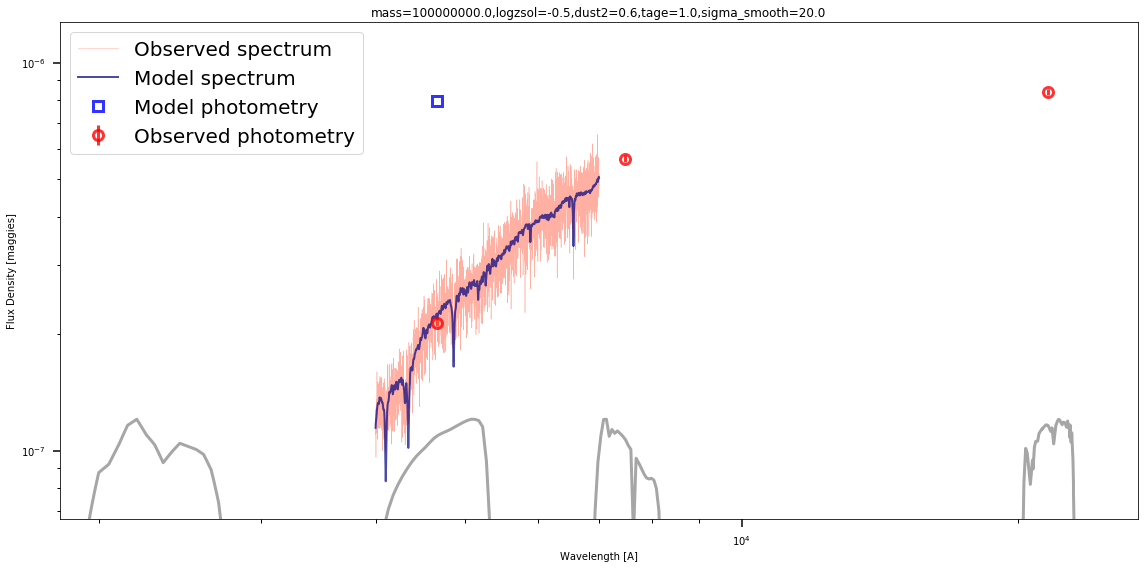

In [15]:
# Generate the model SED at the initial value of theta
# Note that this *includes* the maximum-likelihood polynomial calibration, 
# so the model should by design go roughly through the data, even if the parameters are wrong.
# The photometry, however, will be off.
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.predict(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={}".format(p, model.params[p][0]) 
                       for p in model.free_params])

# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(obs["wavelength"], obs['spectrum'], label='Observed spectrum', 
       lw=0.5, color='tomato', alpha=0.5)
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=2, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


We should see here the data in red and the model in blue.  Because we are computing and applying the maximum likelihood polynomial calibration vector to the model spectrum, it should run through the observed spectrum pretty well by design.  However, the photometry is substantially offset, because these model parameter valuse are not correct!  It's also possible to see some issues in the absorption line depths.  Let's move on to *inferring* the model parameters from the data.  For this we need a likelihood function.

## Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from *prospector*.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in *prospector*.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within *prospector*.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

In [16]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=False, verbose=verbose):
    """
    Given a parameter vector, a model, a dictionary of observational 
    data, and an sps object, return the ln of the posterior. 
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    spec, phot, mfrac = model.predict(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

However, *prospector* comes with a pre-built `lnprobfn` that can incorporate more complex noise models, and can be either return ln-probability or chi-square or a vector of residuals depending on the algorithm being used.  So let's use that:

In [17]:
from prospect.fitting import lnprobfn

# Running Prospector
Now that we have defined the model and set up the data that we want to fit, we are ready to run *prospector*.  We will do this in a few steps.  First we will run all the convenience functions we made earlier to get the fitting ingredients and set up the output.  Then we will fit the model using 1) $\chi^2$ minimization; 2) ensemble MCMC sampler around the best location from the minimization 3) dynamic nested sampling with `dynesty`

In [19]:
# Here we will run all our building functions
obs = build_obs(**run_params)
sps = build_sps(obs=obs, **run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)

(b'mist', b'miles')


We will use, appropriately enough, the `fit_model` method (with different options) for each of the three different ways of fitting the model described above.  Let's take a look at this method. 

In [20]:
from prospect.fitting import fit_model
help(fit_model)

Help on function fit_model in module prospect.fitting.fitting:

fit_model(obs, model, sps, noise=(None, None), lnprobfn=<function lnprobfn at 0x7fb7aad17048>, optimize=False, emcee=False, dynesty=True, **kwargs)
    Fit a model to observations using a number of different methods
    
    :param obs:
        The ``obs`` dictionary containing the data to fit to, which will be
        passed to ``lnprobfn``.
    
    :param model:
        An instance of the :py:class:`prospect.models.SedModel` class
        containing the model parameterization and parameter state.  It will be
        passed to ``lnprobfn``.
    
    :param sps:
        An instance of a :py:class:`prospect.sources.SSPBasis` (sub-)class.
        Alternatively, anything with a compatible :py:func:`get_spectrum` can
        be used here. It will be passed to ``lnprobfn``
    
    :param noise: (optional, default: (None, None))
        A tuple of NoiseModel objects for the spectroscopy and photometry
        respectively.  Ca

Note in particular that the output is a dictionary with *both* optimization and sampling entries.  This is because one can do both within a single call to `fit_model`, and for ensemble sampling in particular it can be useful to do optimization first to get close to the data before beginnning the sampling.

## Minimization
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the `run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, but the `lnprobfn` we imported supports that.

In [21]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 3

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/Users/bjohnson/miniconda3/envs/pro/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log


Done optmization in 146.6708574295044s


### View model after minimization
Now let's see how our model looks in the data space after minimization. The model should already be set to the result of the best optimization, but we can also find the best run and set the model parameters to that result by hand.

[4.26243753e+07 9.67821550e-02 4.37081387e-01 1.34902688e+00
 9.99997137e+01]
0
{'mass': 42624375.313522145, 'logzsol': 0.0967821549559886, 'dust2': 0.43708138692524773, 'tage': 1.3490268810198722, 'sigma_smooth': 99.99971372968668}


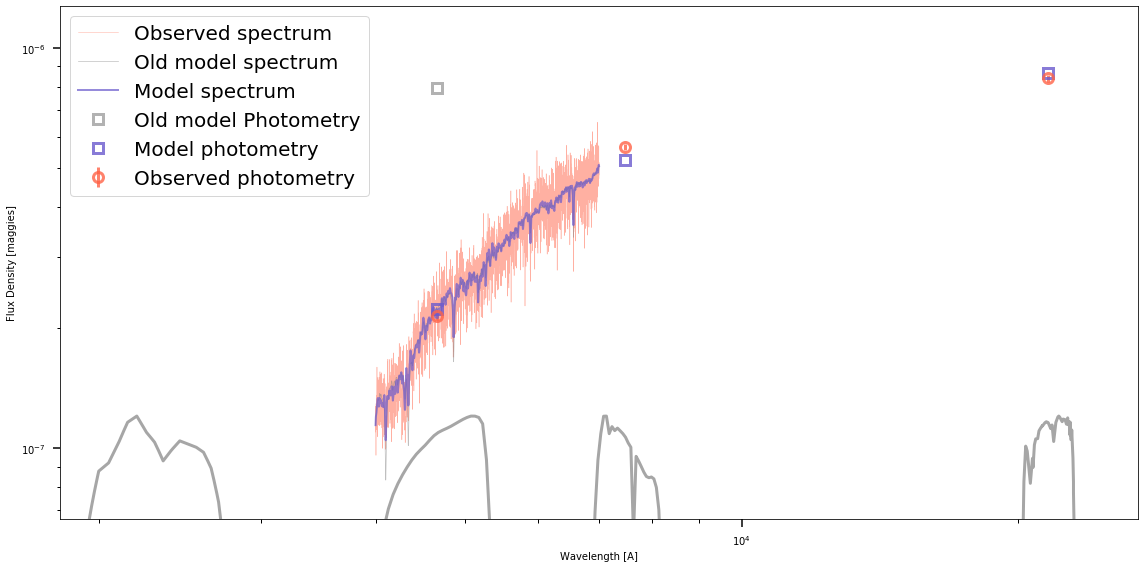

In [22]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(dict(zip(model.free_params, theta_best)))

# generate model
prediction = model.predict(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(obs["wavelength"], obs['spectrum'], label='Observed spectrum', 
       lw=0.5, color='tomato', alpha=0.5)
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=2, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

The photometry _should_ look much better, except maybe for the filters that we have masked out.  The spectrum might look slightly better, but we'd probably have to zoom in to really see the improvment (remember we are optimizing out gross shape offsets). You can also run the minimization cell multiple times to see if the fit gets better.

## Sampling the Posterior: Nested sampling
Instead of ensemble MCMC sampling we can sample using dynamic nested sampling via *dynesty*.  Dynamic nested sampling works by sampling from within successive iso-likelihood contours, transforming a distribution of live points from the prior to the posterior.  It does not benefit from burn-in via optimization.

There are a number of parameters that control the operation of *dynesty*.  A listing and brief description of each is given in the default *prospector* arguments (see below), here we will set just a few of the most important

In [23]:
run_params["dynesty"] = True
run_params["optimize"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [24]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 4495 | batch: 7 | nc: 15 | ncall: 21489 | eff(%): 20.732 | loglstar: 47764.667 < 47769.855 < 47769.005 | logz: 47756.277 +/-  0.479 | stop:  1.239    

done dynesty in 308.71087098121643s


In [26]:
from prospect.io import write_results as writer

# add a tag for the time the file is created
ts = time.strftime("%y%b%d-%H.%M", time.localtime())
hfile = "demo_dynesty_results_{}.h5".format(ts)
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], None,
                  tsample=output["sampling"][1])

print('Finished, wrote results to {}'.format(hfile))

Finished, wrote results to demo_dynesty_results_20Jul17-13.10.h5


/Users/bjohnson/miniconda3/envs/pro/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/Users/bjohnson/miniconda3/envs/pro/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/io/write_results.py:278: RuntimeWarning: Could not JSON serialize model_params, pickled instead


In [27]:
sampler = output["sampling"][0]
print(sampler.keys())

dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds'])


## Command-line operation

The preferred way to use prospector is through command line operation.  This is difficult to demonstrate in a notebook, but essentially one would place the `build_obs`, `build_model`, and `build_sps` methods in a single **parameter file**.  Then, in the `__main__` portion of the **parameter file** the entries of the `run_params` dictionary would be set via command-line arguments (via `argparse`), the `build_*` methods would be run, and `fit_model` would be called. For an example please see `demo_params.py` and `demo_mock_params.py` in the prospector demo directory.

A number of options used by the code are available in a prebuilt argument parser, which can be augmented with anything necessary for the `build_*` methods that you create.  Below is an example.

In [28]:
from prospect import prospect_args
# - Parser with default arguments -
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--object_name', type=str, default="gc1",
                    help="Filename root for data.")
parser.add_argument('--add_neb', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--luminosity_distance', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"))
parser.add_argument('--remove_spec_continuum', action="store_true",
                        help="Whether to optimize out a continuum polynomial")
parser.add_argument('--set_lsf', action="store_true",
                    help="Whether to smooth the SSPs to the instrumental resolution")


args, _ = parser.parse_known_args()
cli_run_params = vars(args)
print(cli_run_params)

{'verbose': 1, 'debug': False, 'outfile': 'prospector_test_run', 'output_pickle': False, 'zcontinuous': 1, 'optimize': False, 'min_method': 'lm', 'min_opts': {}, 'nmin': 1, 'emcee': False, 'nwalkers': 64, 'niter': 512, 'nburn': [16, 32, 64], 'interval': 0.2, 'restart_from': '', 'initial_disp': 0.1, 'dynesty': False, 'nested_bound': 'multi', 'nested_method': 'slice', 'nested_nlive_init': 100, 'nested_nlive_batch': 100, 'nested_dlogz_init': 0.05, 'nested_maxcall': 50000000, 'nested_maxbatch': 10, 'nested_bootstrap': 0, 'nested_posterior_thresh': 0.05, 'object_name': 'gc1', 'add_neb': False, 'luminosity_distance': 10, 'remove_spec_continuum': False, 'set_lsf': False}


You can then run this from the command line as as e.g.
```
python demo_params.py --outfile gc1_dynesty --object_name gc1 --remove_spec_continuum --set_lsf \
                      --dynesty --nested_method rwalk --nested_posterior_thresh 0.05
```

# Visualizing the Results
There are a few basic plotting tools available to do a quick check on the results available in `prospect.io.read_results` and `prospect.utils.plotting`. But first we need to read the output files we made.

## Reading output files
Reading our results from our HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and in some situations the `SedModel` object that was used in the fitting.

In this example we will look at the *emcee* results file that we created, but you can do the same for the *dynesty* results file.  The main difference is that the chains for each fit type have a different dimensionality, and that the samples in the *dynesty* chains come with associated **weights**.  The weights and different shapes are handled automatically by the plotting functions included in *prospector*, but custom plotting code should take care of the difference.

In this notebook we have already defined the `model` (and `sps`) object, but in general one will want to recreate it.  *Prospector* allows you to do this by storing the `build_model` and `build_sps` code as text in the HDF5 file -- this is possible with the use of *parameter files* and command line operation.

In [29]:
import prospect.io.read_results as reader
results_type = "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from(hfile, dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'chain', 'efficiency', 'information', 'lnlikelihood', 'lnprobability', 'logvol', 'logz', 'logzerr', 'niter', 'samples_id', 'weights', 'ncall', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)  You can use these plots (and the chains more generally) to assess whether the MCMC has converged, or if you need to sample for more iterations.

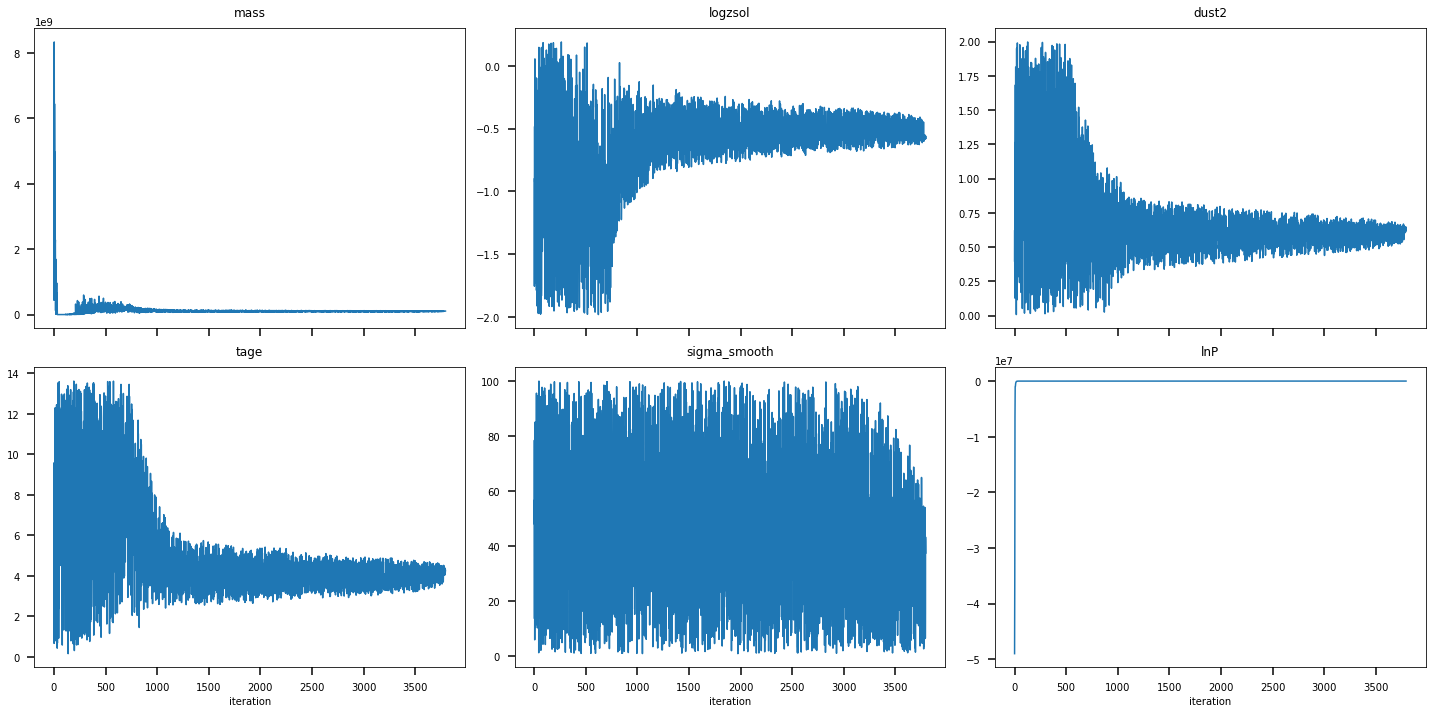

In [30]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

Optimization value: [4.26243753e+07 9.67821550e-02 4.37081387e-01 1.34902688e+00
 9.99997137e+01]
MAP value: [ 9.39782002e+07 -4.51952811e-01  5.59089283e-01  3.71277499e+00
  4.20418123e+01]


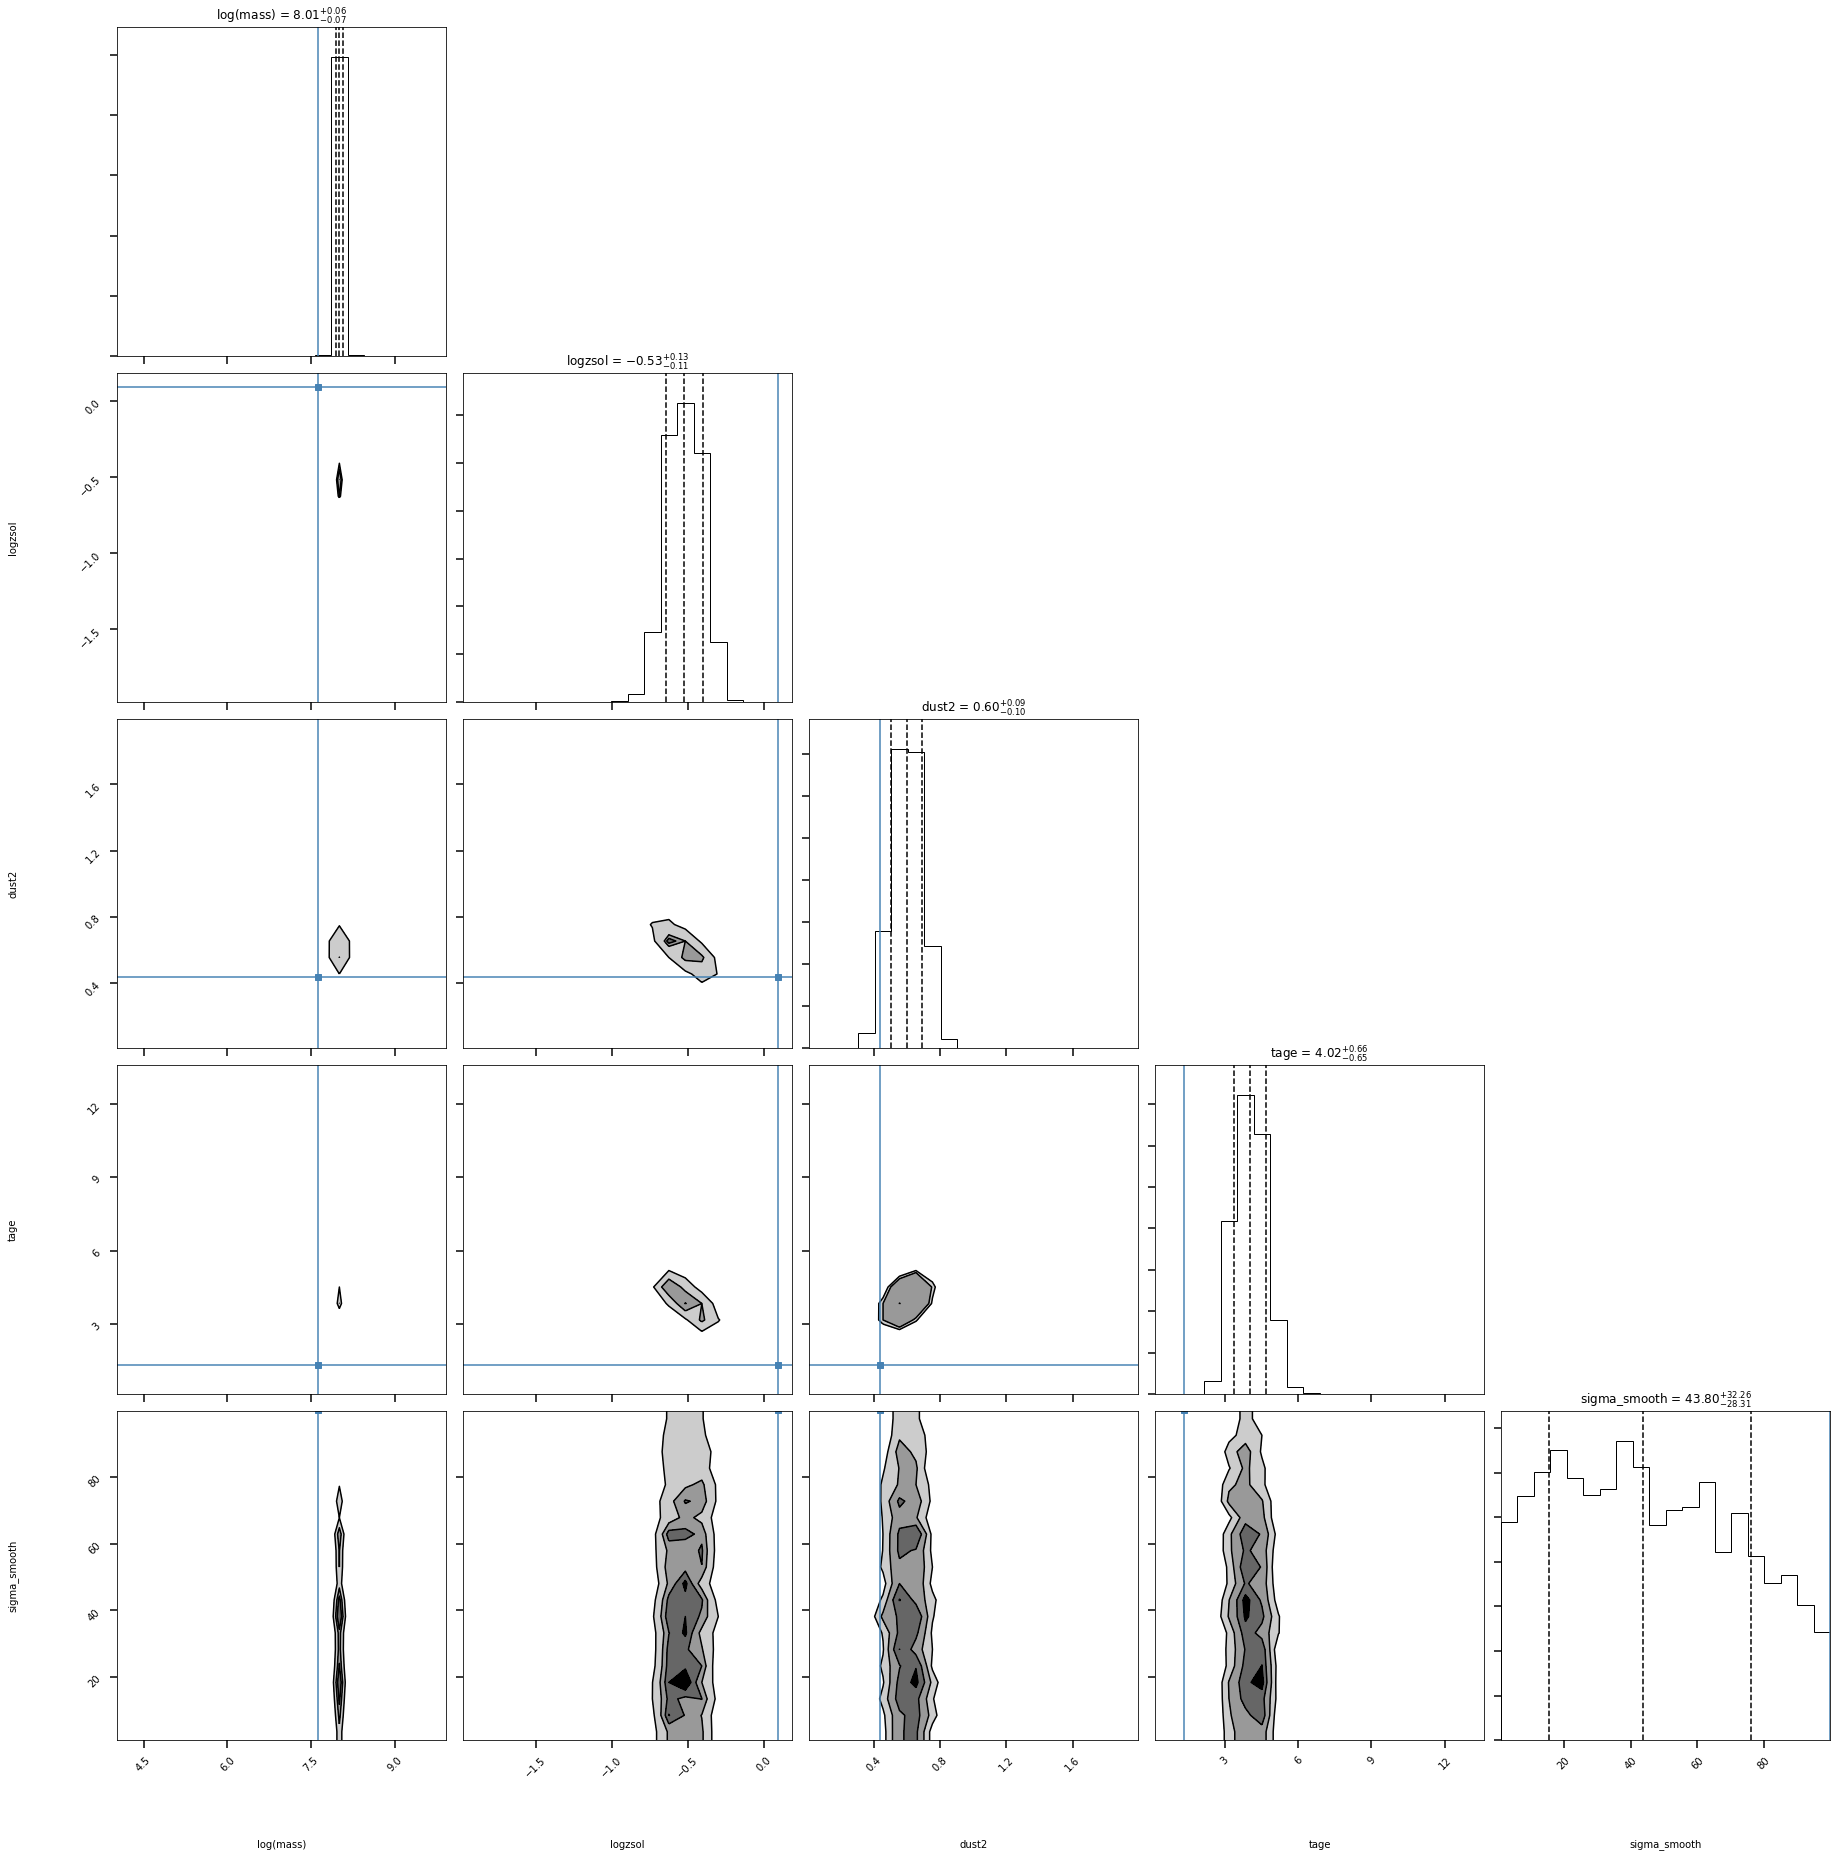

In [31]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(5,5,figsize=(27,27))[0])

Or, even prettier, use the dynesty methods which autoscale the range and apply a KDE filter:

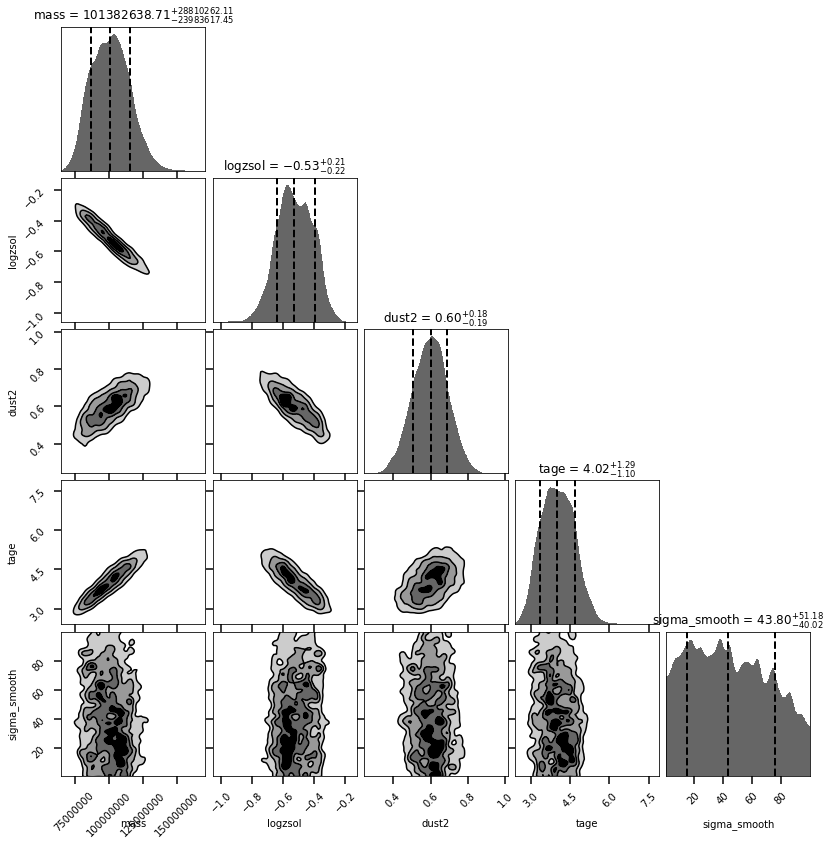

In [32]:
from dynesty import plotting as dyplot
dres = {"samples": result["chain"], "logl": result["lnlikelihood"], "weights": result["weights"]}
cfig = dyplot.cornerplot(dres, labels=result["theta_labels"], show_titles=True, quantiles=[0.16, 0.5, 0.84])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

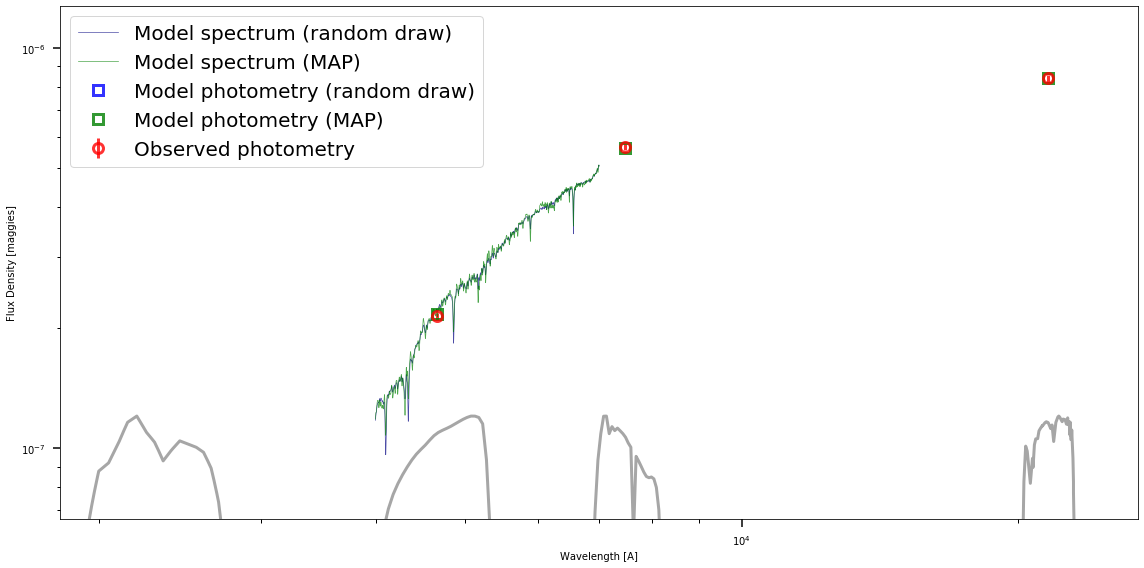

In [33]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.predict(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.predict(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()